# Language model

Language model is a probability distribution over sequences of word.

In this lab we will apply laguage model for a classification problem. The task is to implement a filter for spam documents.

Read this article
https://towardsdatascience.com/learning-nlp-language-models-with-real-data-cdff04c51c25

### Dataset
Download this https://www.kaggle.com/uciml/sms-spam-collection-dataset dataset.
Normalize the text and split by sentences using nltk library. Split sentences to the terms. We don't need to do lemmatize words and remove stop words. For simplicity we will lose the punctuation and characters register.
Make a lists of sentences for spam and ham messages.

In [2]:
import pandas as pd
df = pd.read_csv('./data/spam.csv',delimiter=',',encoding='latin-1')

df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
!pip install unidecode

In [4]:
import re
import nltk
import unidecode

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jafar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jafar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jafar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def normalize(text, is_query=False):
    text = unidecode.unidecode(text)  # remove accents
    text = text.replace('+', ' ')
    text = re.sub('(\w)', lambda m: m.group(0).lower(), text)  # to_lower the entire text
    if is_query:
        text = re.sub('[^a-z $ *]', "", text)  # remove punctuations
    else:
        text = re.sub('[^a-z ]', "", text)
    text = re.sub('(\ +)', " ", text)  # if we have more than one white space it will become one

    return text

normalize('Hello there my master the, th')

'hello there my master the th'

In [6]:
sentences = list(zip(map(normalize, df.v2),df.v1))
spam_sentences = list(filter(lambda x: True if x[1] =='spam' else False , sentences))#list of sentences, each sentence represented as a list of terms
ham_sentences = list(filter(lambda x: True if x[1] =='ham' else False , sentences))


spam_num_sentences = list(map(lambda x:x[0].count('.'),spam_sentences))
tokenize = lambda x: x[0].split(' ')
spam_sentences = list(map(tokenize,spam_sentences))
ham_sentences = list(map(tokenize,ham_sentences))

split =  len(spam_sentences) * 9 // 10
test_spam = spam_sentences[split:]
spam_sentences = spam_sentences[:split]

split =  len(ham_sentences) * 9 // 10
test_ham = ham_sentences[split:]

ham_sentences = ham_sentences[:split]
print('Spam', 'Ham')
print(len(spam_sentences), len(ham_sentences))

Spam Ham
672 4342


# clean up
un-needed variables deletion to save up ram

In [7]:
del sentences
del df

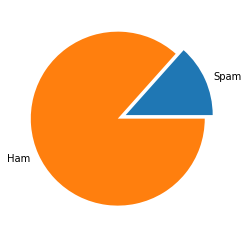

In [8]:
import matplotlib.pyplot as plt

x = [len(spam_sentences), len(ham_sentences)]
plt.pie(x, explode=(0,0.1), labels=['Spam', 'Ham'])
plt.show()

Print the average length and average number of sentences in spam message.

In [9]:
import functools
avg_length = (functools.reduce(lambda a,b:len(a) + len(b) \
    if isinstance(a,list) else a + len(b),spam_sentences))/len(spam_sentences)

avg_sentences = sum(spam_num_sentences)/len(spam_sentences)

print(f'Average length: {avg_length}, Average amount of sentences: {avg_sentences}')
del avg_sentences
del avg_length

num_of_words = functools.reduce(lambda a,b:len(a) + len(b) \
    if isinstance(a,list) else a + len(b),spam_sentences+ham_sentences)

Average length: 21.870535714285715, Average amount of sentences: 0.0


### Unigram model

Calculate the number of occurances of each term separately for spam and ham messages.

Calculate the total number of terms.

In [10]:
spam_words = functools.reduce(lambda a,b:set(a).union(b),spam_sentences)
ham_words = functools.reduce(lambda a,b:set(a).union(b),ham_sentences)
print(len(spam_words), len(ham_words))

2182 6974


In [11]:
def count_word(sentences, word):
    import sys
    #print(f'Getting count for word {word} please wait',end='', flush=True)
    sys.stdout.flush()

    return functools.reduce(lambda a,b: a.count(word) + b.count(word) if isinstance(a,list)\
                            else a + b.count(word),sentences)
ham_N = len(ham_words)
spam_N = len(spam_words)
spam_term_c = dict(zip(spam_words,map(lambda a:count_word(spam_sentences, a)\
                                      /spam_N,spam_words)))

ham_term_c =dict(zip(ham_words,map(lambda a:count_word(ham_sentences, a)\
                                   /ham_N,ham_words)))


In [12]:
print(ham_term_c['sentence'],sep='\n')

0.0004301691998852882


Print 10 most popular words in spam messages.

In [13]:
x = list(reversed(sorted(list(zip(map(lambda a:spam_term_c[a],\
                                      spam_words),spam_words)))))
print(*x[:10],sep='\n')

(0.2832263978001833, 'to')
(0.15490375802016498, 'a')
(0.13932172318973418, 'call')
(0.11732355637030248, 'you')
(0.10861594867094408, 'aps')
(0.10724106324472961, 'your')
(0.09074243813015583, '')
(0.08845096241979836, 'free')
(0.08340971585701192, 'the')
(0.08065994500458296, 'now')


### Bigram model

We will use sentence beginning and sentence ending as a special terms. Calculate the number of occuracnies for bigrams. As a key in dictionary you might use words, separated by the space symbol.

Also, for a genetative model, epxlained later, for each term we will need a list of next term, found in the dataset.

In [14]:
modify = lambda x: ['<s']+x+['s>']
ham_sentences = list(map(modify,ham_sentences))
spam_sentences = list(map(modify,spam_sentences))

In [24]:
def add_bigrams(sentences):
    big = set([])
    for sentence in sentences:
        for i in range(0,len(sentence)-1):
            big.add(' '.join([sentence[i],sentence[i+1]]))
    return big


def count_bigs(sentences, index):

    for sentence in sentences:
        for i in range(0,len(sentence)-1):
            index[' '.join([sentence[i],sentence[i+1]])]+=1/len(index.keys())
    return index

def get_next_spam_word(spam_bigram_c):
    res = dict()
    x = list(reversed(sorted(list(zip(map(lambda a:spam_bigram_c[a],\
                                      spam_bigram_c.keys()),spam_bigram_c.keys())))))
    for _,big in iter(x):
        first_word,second_word= iter(big.split(' '))
        if first_word in res.keys():
            res[first_word].append(second_word)
            continue
        res[first_word] = [second_word]
    return res

In [25]:
bigrams = add_bigrams(spam_sentences)
bigrams = bigrams.union(add_bigrams(ham_sentences))
spam_bigram_c = dict(zip(list(bigrams),[0]*len(bigrams)))


spam_bigram_c = count_bigs(spam_sentences,spam_bigram_c)

spam_next_words = get_next_spam_word(spam_bigram_c)

ham_bigram_c = dict(zip(list(bigrams),[0]*len(bigrams)))
ham_bigram_c= count_bigs(ham_sentences, ham_bigram_c);

Which bigrams are the most popular in spam messages?

From which words spam sentence usually begins?

In [17]:
x = list(reversed(sorted(list(zip(map(lambda a:spam_bigram_c[a],\
                                      bigrams),bigrams)))))
print(*x[:10],sep='\n')


(0.004183076885442399, ' s>')
(0.001565596027300081, 'you have')
(0.001565596027300081, 'a aps')
(0.0012965092101078796, 'call now')
(0.001149734582548497, 'have won')
(0.001149734582548497, '<s urgent')
(0.0011008097066953694, 'aps prize')
(0.0011008097066953694, '<s you')
(0.001051884830842242, 'your mobile')
(0.0010274223929156781, 'to claim')


Implement a function, which return the conditional probability $P(t_2 | t_1)$

In [18]:
def conditional_prob(t1, t2, spam=True):
    bigram_c = ham_bigram_c
    unigram_c = ham_term_c
    if spam:
        bigram_c = spam_bigram_c
        unigram_c = spam_term_c
    try:
        a = unigram_c[t1]
    except:
        a = 0
    try:
        b =  bigram_c[' '.join([t1,t2])]
    except:
        b = 0
    #print(a,b)
    return b/a
print("t1 = I, t2 = am",conditional_prob('you', 'have'))
print("t1 = I, t2 = is",conditional_prob('i', 'am'))

t1 = I, t2 = am 0.013344259888940535
t1 = I, t2 = is 0.006535964027236179


### Genetative model

Now is the funny task. Using your language model generate a spam message. Remember you calculated the average number of sentences, average sentence size for spam messages.

Print few generated ouptuts.

In [32]:
import random

def generate_spam_message(spam_next_words,L=23, seed=None):
    if not seed:
        gen = random.randint(0,len(spam_next_words.keys()))

        seed = list(spam_next_words.keys())[gen]
    res = seed
    for i in range(L):
        if not seed in spam_next_words.keys():
            gen = random.randint(0,len(spam_next_words.keys()))

            seed = list(spam_next_words.keys())[gen]
        gen = random.randint(0,len(spam_next_words[seed])-1)
        #print(gen, spam_next_words[seed][gen])
        res = res +' '+ spam_next_words[seed][gen]
        seed = spam_next_words[seed][gen]
    return res

seeds = ['I', 'You']
for seed in seeds:
    print(generate_spam_message(spam_next_words,23,seed))

I u darlinim cool ill stay whats nannys address it the latest gs still let this txt bundle deals also tel vikky vl givits
You our money for driving even move my intention to attend ur hmv to aps tb ok already wat izzit because of hours slave


### Smoothing

The problem is that if the bigram $t_1 t_2$ occuted $0$ times in the corpus, the conditional probability $P(t_2|t_1) = 0$

The solution is smoothing. Read this document https://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf

Your task is to implement one of the advanced (from the document, except additive smoothing) smoothing techniques from it. Be ready to explain it defending the lab.

Implement a function, which return the conditional probability $P(t_2 | t_1)$ with a smoothing.

In [33]:
def turing_good(ngram):
  probs = list(map(lambda x: (ngram[x],x) ,ngram.keys()))
  probs = list((sorted(probs)))
  d = dict()
  probabilities = []
  keys = []
  for i in range(len(probs)):
    p = probs[i][0]
    if p in d.keys():
      d[p]+=1
    else:
      d[p] = 1
   
  for i in range(len(probs)-1):
    p = probs[i][0]
    key = probs[i][1]
    nr = d[p]
    nr_plus_1 = d[probs[i+1][0]]
    N = len(ngram.keys())
    p = (p + 1/N/N) * nr / nr_plus_1 #nr_plus_1 / nr
    probabilities.append(p)
    keys.append(key)
  return dict(zip(keys,probabilities))
    

def smoothing_conditional_prob(t1, t2, spam=True):
    bigram_c = ham_bigram_c
    unigram_c = ham_term_c
    if spam:
        bigram_c = spam_bigram_c
        unigram_c = spam_term_c
    N = len(bigram_c.keys())
    z = 1/N
    v = 1/(N**2)
    try:
        a = bigram_c[' '.join([t1,t2])]
    except:
        a = v
    try:
        b =  unigram_c[t1]
    except:
        b = z
    return ( a  )/( b)

ham_bigram_c = turing_good(ham_bigram_c)
spam_term_c = turing_good(spam_term_c)
ham_term_c = turing_good(ham_term_c)
spam_bigram_c = turing_good(spam_bigram_c)


smoothing_conditional_prob('I', 'allah') # // it should be zero nonetheless

2.4463036352072017e-05

### Classification

Now, implement a bayessian classifier for the sentence. Test one of your generated sentences on it.

It should return, which probability is higher

$$P(spam|t_1, \dots , t_k) = \frac{P(t_1, \dots , t_k|spam)P(spam)}{P(t_1, \dots , t_k)} \sim P(t_1, \dots , t_k|spam)P(spam)$$ 
$$\sim P(t_1 | BEGIN, spam) \cdot \sim P(t_2 | t_1, spam) \cdot \dots \cdot \sim P(END | t_k, spam)$$

or the same for ham sentence.

In [34]:
import math
def classify(sentence):
    tokens = sentence.split(' ')
    log_spam = math.log(smoothing_conditional_prob('<s', tokens[0],spam=True))
    log_ham = math.log(smoothing_conditional_prob('<s', tokens[0],spam=False))

    for i in range(len(tokens)-1):
        log_spam += math.log(smoothing_conditional_prob(tokens[i],tokens[i+1],spam=True))

        log_ham += math.log(smoothing_conditional_prob(tokens[i],tokens[i+1],spam=False))

    return  'Spam' if log_spam > log_ham else 'Ham'

def evaluate(test_data, labels):
  res = 0
  for test_sentence, label in iter(zip(test_data,labels)):
    if classify(' '.join(test_sentence)) == label:
      res+=1
  return res/len(test_data) * 100


test_data = test_spam + test_ham
test_labels = ['Spam'] * len(test_spam) + ['Ham'] * len(test_ham)

training_data = spam_sentences + ham_sentences
training_labels = ['Spam'] * len(spam_sentences) + ['Ham'] * len(ham_sentences)

print(f'Training accuracy is {evaluate(training_data, training_labels)} %')
print(f'Test accuracy is {evaluate(test_data, test_labels)} %')


Training accuracy is 100.0 %
Test accuracy is 93.01075268817203 %
